# Pancreas endocrinogenesis E1415 - Waddington OT

### Imports and Settings

In [1]:
import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

import anndata as ad
import scanpy as sc
import scvelo as scv
import cellrank as cr
from cellrank.external.kernels import WOTKernel
from cellrank.estimators import GPCCA
from tueplots import bundles
from tueplots import axes

In [2]:
cr.logging.print_versions()

cellrank==1.5.1+g16069e25 scanpy==1.9.1 anndata==0.8.0 numpy==1.23.5 numba==0.56.4 scipy==1.10.0 pandas==1.5.2 pygpcca==1.0.4 scikit-learn==1.2.0 statsmodels==0.13.5 scvelo==0.2.5 pygam==0.8.0 matplotlib==3.6.2 seaborn==0.12.2


## Data Loading

In [3]:
#adata = sc.read("../neural_ot/data/pancreas/1415_growth_rate.h5ad")
adata_fourteen = sc.read(f"/lustre/groups/ml01/workspace/monge_velo/data/benchmarks/pancreas/day_14.5_growth_rate.h5ad")
adata_fifteen = sc.read(f"/lustre/groups/ml01/workspace/monge_velo/data/benchmarks/pancreas/day_15.5_growth_rate.h5ad")
adata = ad.concat([adata_fourteen, adata_fifteen], merge = 'same')
adata.obs['celltype'] = pd.Series(adata.obs['celltype'], dtype='category')
adata.obs['celltype']

index
AAACCTGAGATCCCGC-1-2         Beta
AAACCTGAGCAGGTCA-1-2       Acinar
AAACCTGCAATGAATG-1-2       Acinar
AAACCTGCAATTGCTG-1-2         Beta
AAACCTGCACAGAGGT-1-2    Fev+ Beta
                          ...    
TTTGTCAGTTGTTTGG-1-3       Ductal
TTTGTCATCCTGCAGG-1-3       Acinar
TTTGTCATCGAATGCT-1-3        Alpha
TTTGTCATCTGTTTGT-1-3      Epsilon
TTTGTCATCTTAACCT-1-3       Acinar
Name: celltype, Length: 20519, dtype: category
Categories (17, object): ['Acinar', 'Alpha', 'Beta', 'Delta', ..., 'Ngn3 High late', 'Ngn3 low EP', 'Tip', 'Trunk']

# Cellrank

### Transition probabilities

In [4]:
wk = WOTKernel(adata, time_key="day")
wk.compute_initial_growth_rates(organism="mouse", key_added="growth_rate_init")
wk.compute_transition_matrix(
    growth_iters=3, growth_rate_key="growth_rate_init", 
    #self_transitions="all",
    #conn_weight=0.2
)

100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [12:57<00:00, 777.79s/time pair]


WOTKernel

## Alternatively load precomputed adata

### Macrostate calculation

In [5]:
g = GPCCA(wk)

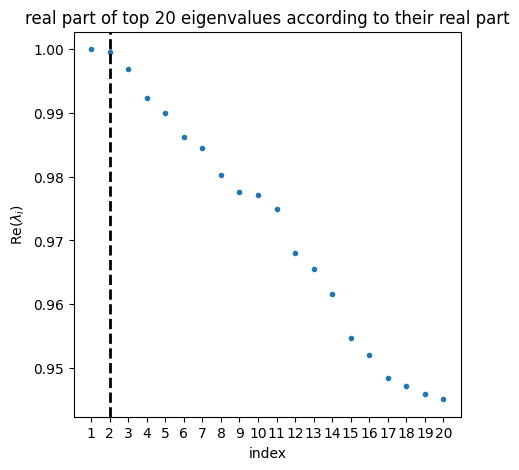

In [6]:
g.compute_schur(n_components=20)
g.plot_spectrum(real_only=True)

In [34]:
adata.obs['celltype'].unique()

['Beta', 'Acinar', 'Fev+ Beta', 'Trunk', 'Ngn3 High late', ..., 'Fev+ Delta', 'Fev+ Epsilon', 'Fev+ Pyy', 'Ngn3 High early', 'Multipotent']
Length: 17
Categories (17, object): ['Acinar', 'Alpha', 'Beta', 'Delta', ..., 'Ngn3 High late', 'Ngn3 low EP', 'Tip', 'Trunk']

In [ ]:
g.compute_macrostates(n_states=12, cluster_key="celltype")
scv.set_figure_params('scvelo', transparent=True, fontsize=20, color_map='viridis')
g.plot_macrostates(discrete=True, basis="umap", legend_loc="right", legend_fontweight='normal', legend_fontsize='12', dpi=250)

/home/icb/jonas.flor/miniconda3/envs/neuralBenchmark/lib/python3.8/site-packages/scvelo/plotting/scatter.py:614: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(


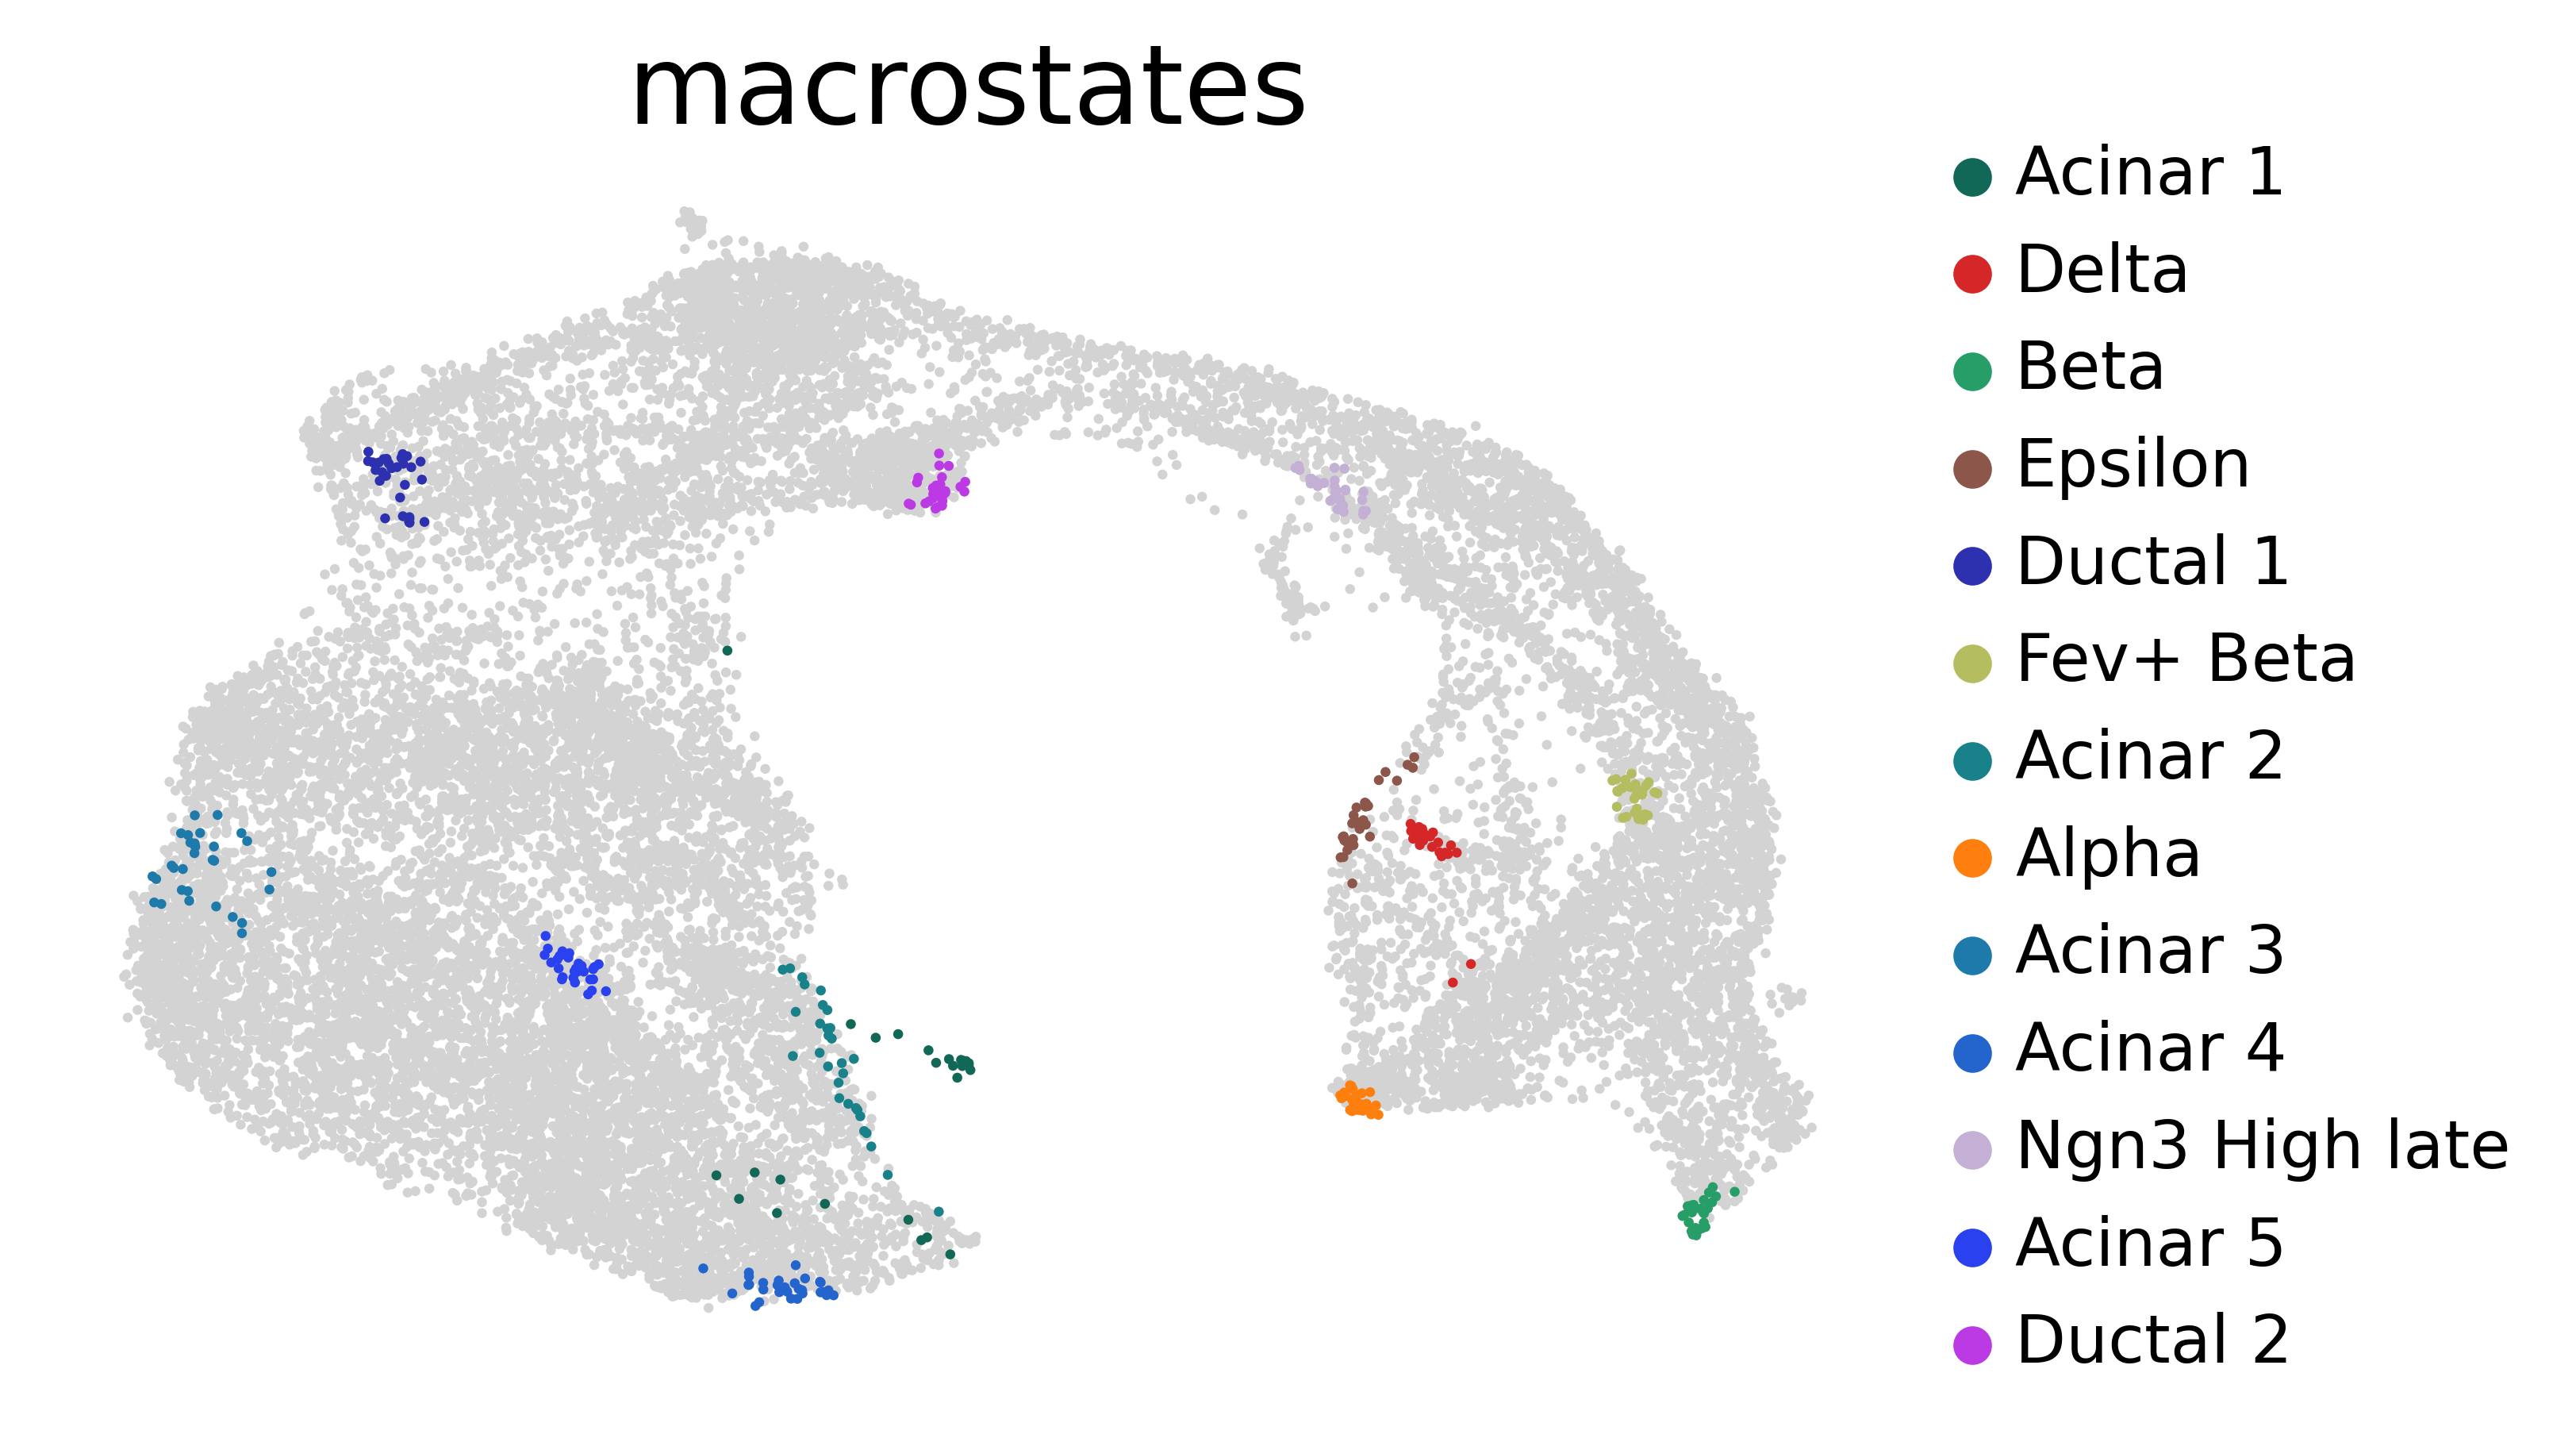

In [16]:
g.compute_macrostates(n_states=13, cluster_key="celltype")
scv.set_figure_params('scvelo', transparent=True, fontsize=20, color_map='viridis')
g.plot_macrostates(discrete=True, basis="umap", legend_loc="right", legend_fontweight='normal', legend_fontsize='12', dpi=250)

### Fate probabilities

100%|███████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.47s/]
/home/icb/jonas.flor/miniconda3/envs/neuralBenchmark/lib/python3.8/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


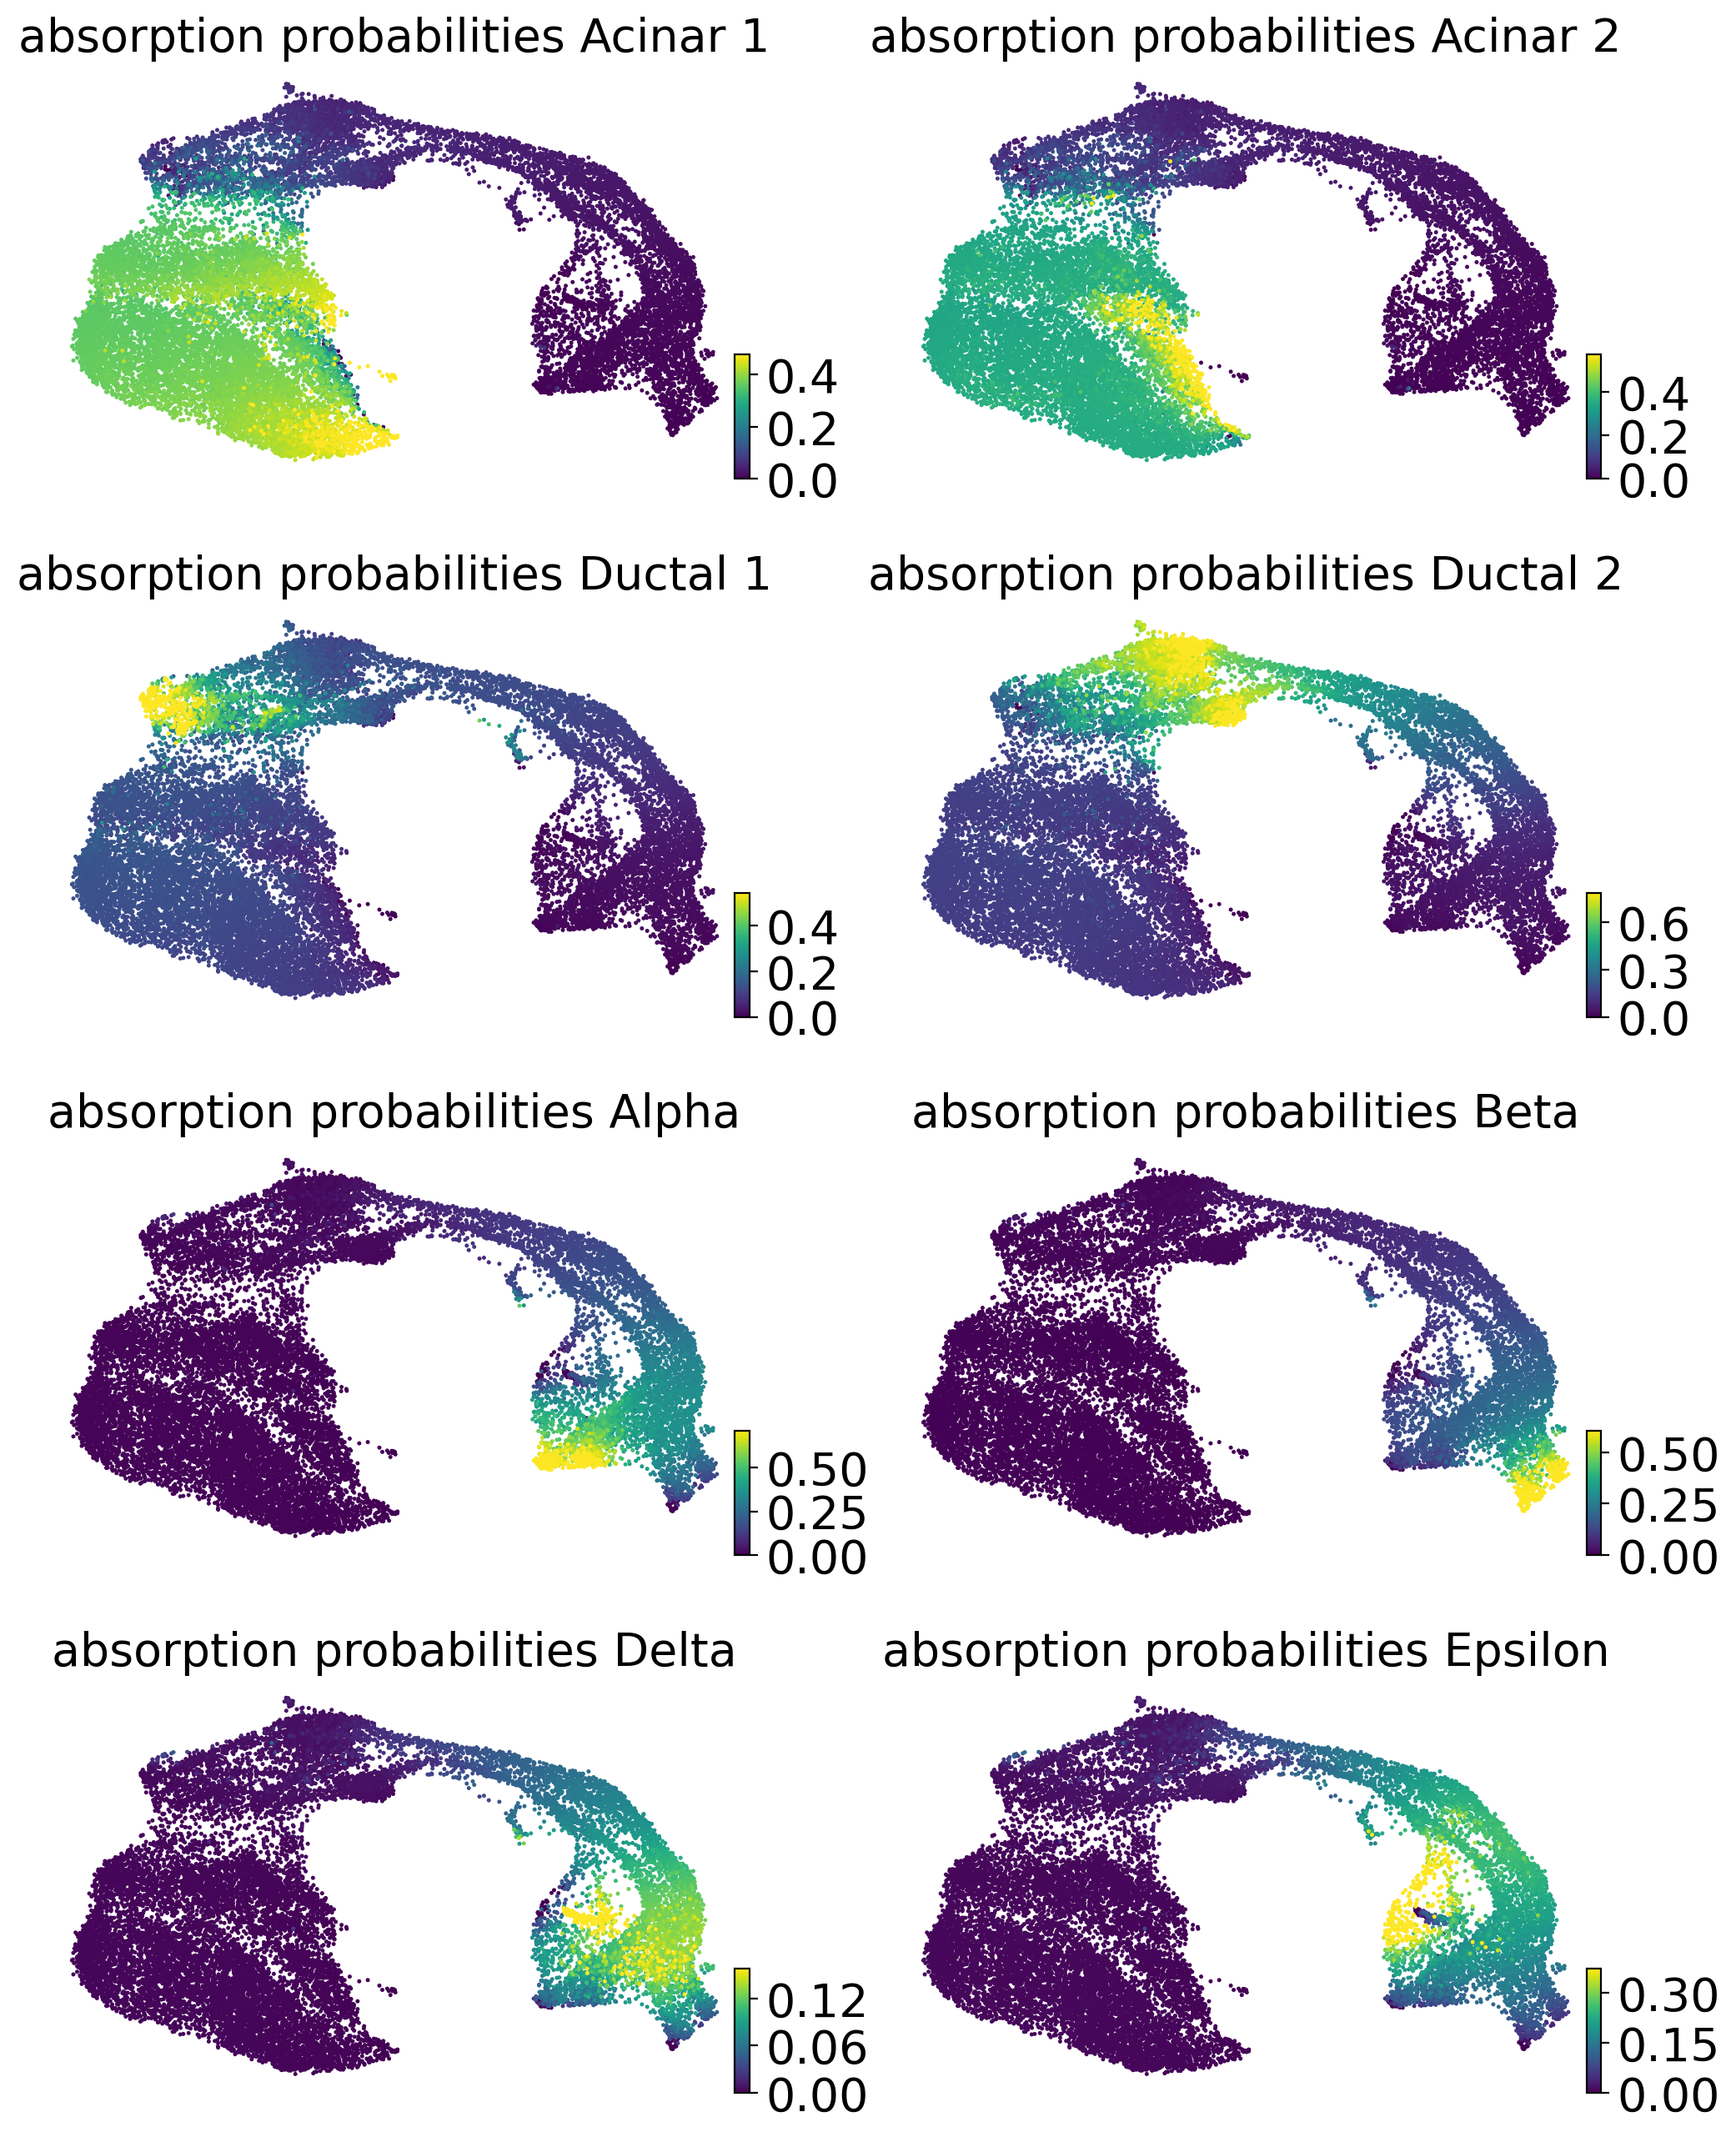

In [19]:
g.set_terminal_states_from_macrostates(
    [
        "Acinar_1", "Acinar_2", "Ductal_1", "Ductal_2", "Alpha", "Beta", "Delta", "Epsilon"
    ]
)
g.compute_absorption_probabilities(solver="gmres", use_petsc=True, tol=1e-12, preconditioner='ilu', time_to_absorption='all')
g.plot_absorption_probabilities(same_plot=False, basis="umap", perc=[0, 99], ncols=2)

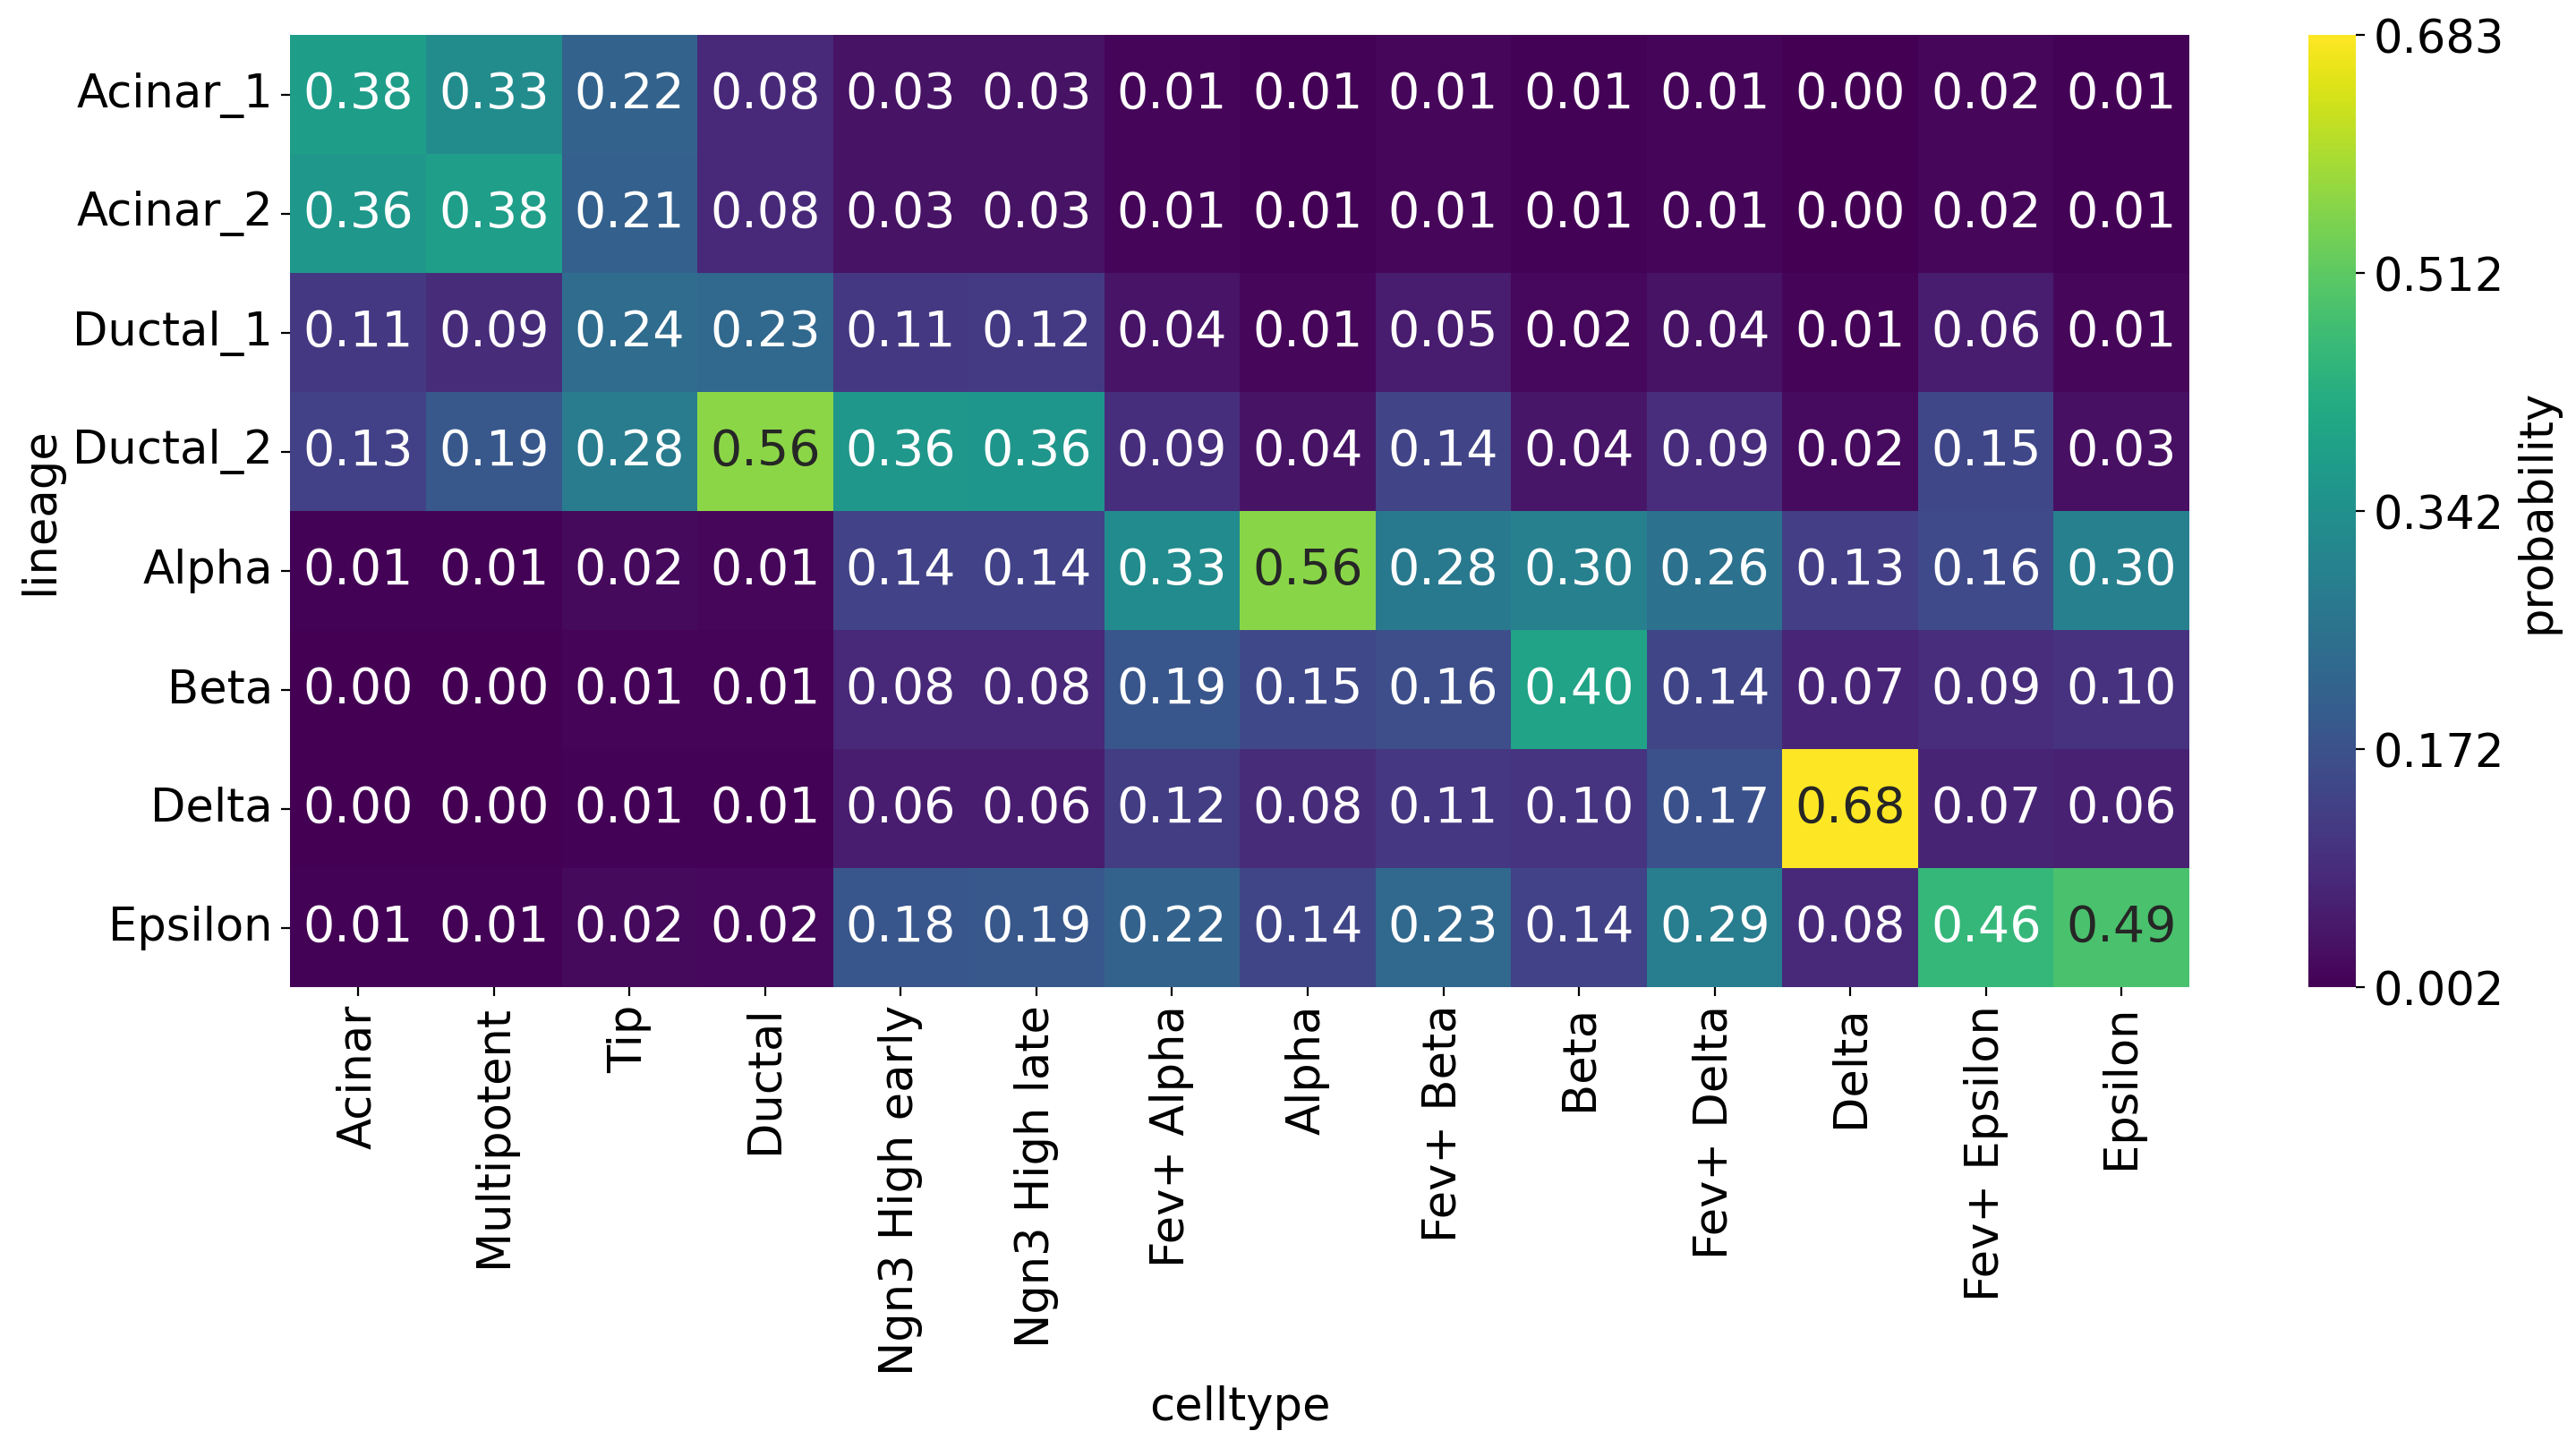

In [20]:
cr.pl.aggregate_absorption_probabilities(
    adata,
    mode='heatmap',
    lineages=["Acinar_1", "Acinar_2", "Ductal_1", "Ductal_2", "Alpha", "Beta", "Delta", "Epsilon"],
    cluster_key='celltype',
    clusters=['Acinar', 'Multipotent', 'Tip', 'Ductal', 'Ngn3 High early', 'Ngn3 High late', 'Fev+ Alpha', 'Alpha', 'Fev+ Beta', 'Beta', 'Fev+ Delta', 'Delta', 'Fev+ Epsilon', 'Epsilon'],
    figsize=(17, 7),
    title="",
    #save="transprobs_wot.png"
)

In [17]:
adata.write("/home/icb/jonas.flor/precomputed_data/wot_pan_pre.h5ad")

In [18]:
adata

AnnData object with n_obs × n_vars = 20519 × 16206
    obs: 'day', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'proliferation', 'G2M_score', 'S_score', 'clusters_fig3_final', 'clusters_fig3_final_noep', 'clusters_fig4_final', 'clusters_fig2_final', 'clusters_fig6_broad_final', 'clusters_fig6_fine_final', 'clusters_fig6_alpha_final', 'celltype', 'prolif', 'apoptosis', 'growth_rate', 'scaled_growth_rate', 'scaled3_growth_rate', 'scaled4_growth_rate', 'proliferation_score', 'apoptosis_score', 'growth_rate_init', 'estimated_growth_rates'
    var: 'n_cells', 'highly_variable_genes', 'expression_mean', 'dispersion', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'day_colors', 'schur_matrix_fwd', 'eigendecomposition_fwd', 'coarse_fwd'
    obsm: 'X_pca', 'X_umap', 'schur_vectors_fwd'
    varm: 'PCs'
    layers: 'spliced', 'unspliced'